<a href="https://colab.research.google.com/github/AidaCPL/BC_Modeling-Sensitivity/blob/main/CBA_Model/CBA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBA Model (edited)

In [72]:
pip install numpy_financial

In [73]:
# Import necessary packages
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd

In [74]:
# Constants
DH_PRICE = 350  # CNY/MWh subject to change
PROJECT_LIFETIME = 40  # years subject to change, taken from paper Appendix D Technical lifetime (years)
DISCOUNT_RATE = 0.035 #subject to change

## Benefits

"Monetize Marginal Social, Health, and Environmental Benefits
Scenario Comparison: Compare a scenario with nuclear residual heating to one without it.
Quantify the following benefits:

* **Social Benefits:** Enhanced comfort from improved heating.
* **Health Benefits:** Longer life expectancy due to better air quality and reduced indoor air pollution.
* **Environmental Benefits:** Avoided emissions (e.g., CO₂, SO₂, NOx).
Start by researching and collecting relevant calculation methods for these benefits."


In [75]:
# Benefits
SOCIAL_BENEFIT = 50  # CNY/MWh, enhanced comfort
HEALTH_BENEFIT = 100  # CNY/MWh, longer life expectancy
ENVIRONMENTAL_BENEFIT = 120  # CNY/MWh, emissions avoided

## Costs Calculations

Quantify the following costs:
* Raw material costs for heating pipelines.
* Construction costs for pipeline infrastructure.
* Costs for relay pump stations, heating stations, and cooling equipment.
* Equipment modification costs.
* Capital and labor costs.
* Nuclear fuel costs.
* Operation and maintenance costs.
* Depreciation and amortization.
* Other costs: land acquisition, management fees, consulting fees, etc."

**Linear Heat Density** = Q_s / L

Where:
L = A_L / w
w = 61.8 * (A_B / A_L)^(-0.15)
A_B = Q_s / Q_B

- Q_s: Annual heat sold to DH consumers (MWh/year)
- A_L: Total land area (m²)
- Q_B: Specific heat demand per building (kWh/m².year)


In [76]:
def linear_heat_density(A_L, Q_s, Q_B):
    A_B = Q_s / Q_B
    w = 61.8 * (A_B / A_L) ** -0.15
    L = A_L / w
    return Q_s / L

**Distribution Cost** = (1570 * d_a + 235) * (Heat Demand / Linear Heat Density)

Where:
d_a = 0.0486 * ln(Linear Heat Density) + 0.06295

- Linear Heat Density (MWh/m·a)
- Heat Demand (MWh/year)

In [77]:
def distribution_cost(linear_heat_density, heat_demand):
    d_a = 0.0486 * np.log(linear_heat_density) + 0.06295
    return (1570 * d_a + 235) * (heat_demand / linear_heat_density)

**Transportation Cost** = (3000 * D² + 4000 * D + 1500) * Distance * 1000

Where:
D = sqrt[ (4 * Heat Demand) / (π * 3 * 3600 * 8760) ]

- Heat Demand (MWh/year)
- Distance: length of heat transport pipeline (km)


In [78]:
def transportation_cost(distance, heat_demand):
    D = np.sqrt((4 * heat_demand / (np.pi * 3 * 3600 * 8760)))
    return (3000 * D**2 + 4000 * D + 1500) * distance * 1000

**Generation Cost** = 100 * Heat Demand

- Heat Demand (MWh/year)
- Assumed constant cost per unit of heat (CNY/MWh)


The Generation Cost in represents the cost associated with the infrastructure required to generate heat for the district heating network. It’s calculated by multiplying a fixed unit cost (assumed as 100 CNY/MWh as an example) by the annual heat demand (MWh/year).

In [94]:
def generation_cost(heat_demand):
    return 100 * heat_demand

**CAPEX** = Distribution Cost + Transportation Cost + Generation Cost


In [80]:
def calculate_capex(heat_demand, distance, linear_density):
    return (distribution_cost(linear_density, heat_demand) +
            transportation_cost(distance, heat_demand) +
            generation_cost(heat_demand))

**OPEX** = 0.03 * CAPEX

- 3% annual operational expenditure assumed as a fraction of CAPEX # subject to change

In [81]:
def calculate_opex(capex):
    return 0.03 * capex

## Economic Indicators

**LCOH** = Annual Cost / Heat Demand

where:
Annual Cost = CAPEX * Annuity Factor + OPEX
Annuity Factor = Discount Rate / (1 - (1 + Discount Rate)^(-Lifetime))

In [82]:
def calculate_lcoh(capex, opex, heat_demand):
    annuity_factor = DISCOUNT_RATE / (1 - (1 + DISCOUNT_RATE)**-PROJECT_LIFETIME)
    annual_cost = capex * annuity_factor + opex
    return annual_cost / heat_demand

**NPV** = -CAPEX + Σ [(Annual Revenue - OPEX) / (1 + Discount Rate)^t]

- Summation from t = 1 to Lifetime (years)
- Annual Revenue: Revenue from heat sold annually (CNY/year)

In [83]:
def calculate_npv(capex, opex, annual_revenue):
    cash_flows = [-capex] + [annual_revenue - opex] * PROJECT_LIFETIME
    return npf.npv(DISCOUNT_RATE, cash_flows)

0 = -CAPEX + sum((Annual Revenue - OPEX) / (1 + **IRR**)^t for each year t from 1 to Lifetime)

In [84]:
def calculate_irr(capex, opex, annual_revenue):
    cash_flows = [-capex] + [annual_revenue - opex] * PROJECT_LIFETIME
    return npf.irr(cash_flows)

**Payback Period** = CAPEX / (Annual Revenue - OPEX)

In [85]:
def calculate_payback(capex, opex, annual_revenue):
    return capex / (annual_revenue - opex)

## Marginal GHG Abatement Cost

**Marginal GHG Abatement Cost** = (LCOH × Q_DH) / ((E_BAU - E_DH_NCHP) × Q_DH)

* LCOH: Levelized Cost of Heat
* Q_DH: Annual heat delivered by DH (MWh/year)
* E_BAU: Emission factor for business-as-usual system (tCO2/MWh)
* E_DH_NCHP: Emission factor for nuclear combined heat and power system (tCO2/MWh)

In [86]:
def marginal_ghg_cost(LCOH, Q_DH, E_BAU, E_DH_NCHP):
    emissions_avoided = (E_BAU - E_DH_NCHP) * Q_DH
    return LCOH * Q_DH / emissions_avoided

## Testing with example data

In [96]:
# Example data
cities_data = pd.DataFrame([
    {"city": "Shanghai", "A_L": 750000, "Q_s": 45000, "Q_B": 160, "distance": 15, "E_BAU": 0.28, "E_DH_NCHP": 0.05},
    {"city": "Ningbo", "A_L": 600000, "Q_s": 38000, "Q_B": 155, "distance": 18, "E_BAU": 0.29, "E_DH_NCHP": 0.05},
    {"city": "Qingdao", "A_L": 680000, "Q_s": 41000, "Q_B": 150, "distance": 20, "E_BAU": 0.31, "E_DH_NCHP": 0.05},
    {"city": "Dalian", "A_L": 650000, "Q_s": 42000, "Q_B": 148, "distance": 25, "E_BAU": 0.32, "E_DH_NCHP": 0.05},
    {"city": "Xiamen", "A_L": 580000, "Q_s": 35000, "Q_B": 158, "distance": 12, "E_BAU": 0.27, "E_DH_NCHP": 0.05},
    {"city": "Fuzhou", "A_L": 630000, "Q_s": 36000, "Q_B": 152, "distance": 17, "E_BAU": 0.30, "E_DH_NCHP": 0.05},
    {"city": "Yantai", "A_L": 700000, "Q_s": 40000, "Q_B": 149, "distance": 22, "E_BAU": 0.33, "E_DH_NCHP": 0.05},
    {"city": "Weihai", "A_L": 610000, "Q_s": 34000, "Q_B": 160, "distance": 19, "E_BAU": 0.28, "E_DH_NCHP": 0.05},
    {"city": "Wenzhou", "A_L": 590000, "Q_s": 37000, "Q_B": 153, "distance": 14, "E_BAU": 0.29, "E_DH_NCHP": 0.05},
    {"city": "Lianyungang", "A_L": 720000, "Q_s": 39000, "Q_B": 151, "distance": 24, "E_BAU": 0.31, "E_DH_NCHP": 0.05},
    {"city": "Zhoushan", "A_L": 640000, "Q_s": 33000, "Q_B": 157, "distance": 13, "E_BAU": 0.27, "E_DH_NCHP": 0.05},
    {"city": "Rizhao", "A_L": 690000, "Q_s": 38000, "Q_B": 155, "distance": 23, "E_BAU": 0.32, "E_DH_NCHP": 0.05},
    {"city": "Taizhou", "A_L": 710000, "Q_s": 36000, "Q_B": 154, "distance": 21, "E_BAU": 0.30, "E_DH_NCHP": 0.05},
    {"city": "Nantong", "A_L": 670000, "Q_s": 40000, "Q_B": 152, "distance": 16, "E_BAU": 0.29, "E_DH_NCHP": 0.05},
    {"city": "Jiaxing", "A_L": 660000, "Q_s": 41000, "Q_B": 150, "distance": 15, "E_BAU": 0.28, "E_DH_NCHP": 0.05}
])

cities_data

,city,A_L,Q_s,Q_B,distance,E_BAU,E_DH_NCHP
0,Shanghai,750000,45000,160,15,0.28,0.05
1,Ningbo,600000,38000,155,18,0.29,0.05
2,Qingdao,680000,41000,150,20,0.31,0.05
3,Dalian,650000,42000,148,25,0.32,0.05
4,Xiamen,580000,35000,158,12,0.27,0.05
5,Fuzhou,630000,36000,152,17,0.30,0.05
6,Yantai,700000,40000,149,22,0.33,0.05
7,Weihai,610000,34000,160,19,0.28,0.05
8,Wenzhou,590000,37000,153,14,0.29,0.05
9,Lianyungang,720000,39000,151,24,0.31,0.05


In [97]:
# Updated code to run analysis for each city in the DataFrame

results = []

for idx, city_data in cities_data.iterrows():
    heat_demand = city_data['Q_s']
    linear_density = linear_heat_density(city_data['A_L'], heat_demand, city_data['Q_B'])
    capex = calculate_capex(heat_demand, city_data['distance'], linear_density)
    opex = calculate_opex(capex)

    # Explicitly include benefits
    total_annual_benefits = (SOCIAL_BENEFIT + HEALTH_BENEFIT + ENVIRONMENTAL_BENEFIT) * heat_demand
    annual_revenue_with_benefits = (heat_demand * DH_PRICE) + total_annual_benefits

    # Update economic indicators with the benefits included
    lcoh = calculate_lcoh(capex, opex, heat_demand)
    npv = calculate_npv(capex, opex, annual_revenue_with_benefits)
    irr = calculate_irr(capex, opex, annual_revenue_with_benefits)
    payback = calculate_payback(capex, opex, annual_revenue_with_benefits)
    mg_ghg_cost = marginal_ghg_cost(lcoh, heat_demand, city_data['E_BAU'], city_data['E_DH_NCHP'])

    results.append({
        "City": city_data['city'],
        "LCOH": lcoh,
        "NPV": npv,
        "IRR": irr,
        "Payback": payback,
        "Marginal GHG Cost": mg_ghg_cost
    })

results_df = pd.DataFrame(results)
results_df

,City,LCOH,NPV,IRR,Payback,Marginal GHG Cost
0,Shanghai,51.989637,5.458456e+08,0.886200,1.128413,226.041902
1,Ningbo,68.829052,4.472712e+08,0.662047,1.510468,286.787719
2,Qingdao,70.822761,4.808365e+08,0.642565,1.556263,272.395234
3,Dalian,83.888140,4.808457e+08,0.537815,1.859377,310.696816
4,Xiamen,52.835242,4.239146e+08,0.871537,1.147398,240.160193
5,Fuzhou,68.817464,4.237395e+08,0.662163,1.510202,275.269854
6,Yantai,78.532365,4.625232e+08,0.576539,1.734489,280.472732
7,Weihai,79.323061,3.925706e+08,0.570493,1.752871,344.882875
8,Wenzhou,57.164837,4.447173e+08,0.803255,1.244934,238.186822
9,Lianyungang,86.615877,4.442278e+08,0.519933,1.923325,333.137987


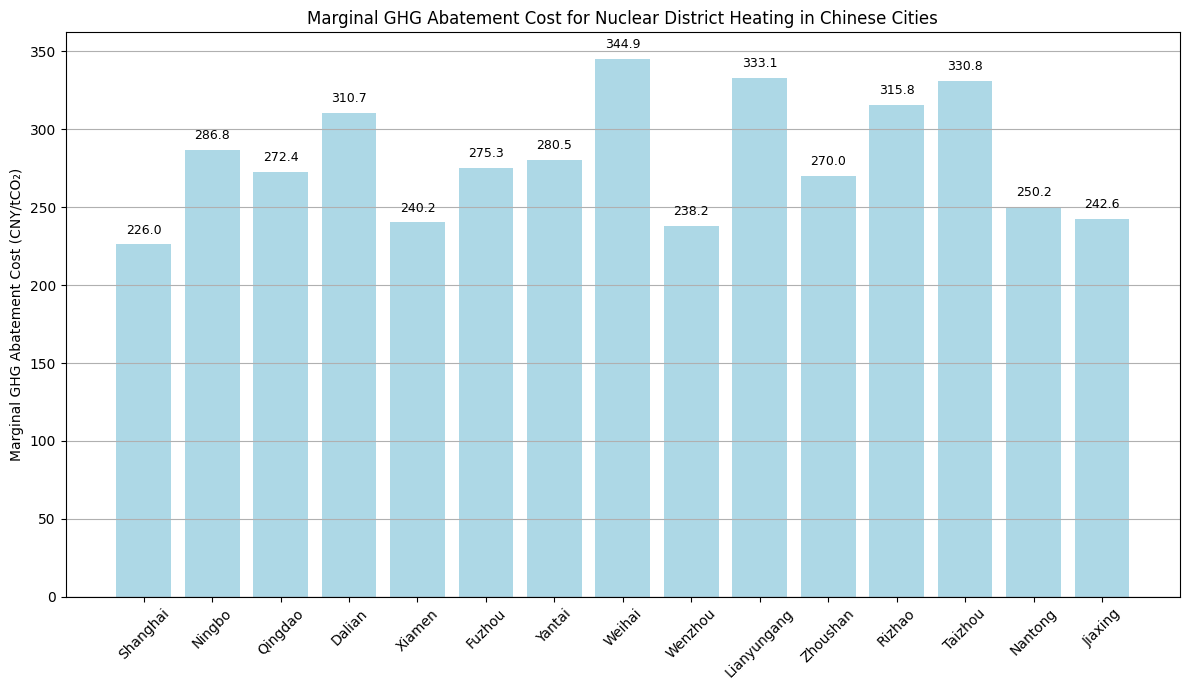

In [89]:
# Visualization FOR Marginal GHG abatement cost
plt.figure(figsize=(12, 7))
bars = plt.bar(results_df['City'], results_df['Marginal GHG Cost'], color=['green' if cost < 0 else 'lightblue' for cost in results_df['Marginal GHG Cost']])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (5 if yval > 0 else -15), f'{yval:.1f}',
             ha='center', va='bottom' if yval > 0 else 'top', fontsize=9)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Marginal GHG Abatement Cost for Nuclear District Heating in Chinese Cities')
plt.ylabel('Marginal GHG Abatement Cost (CNY/tCO₂)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Potential Visualizations:

Marginal GHG Abatement Cost Curve

This type of visualization clearly summarizes both economic and environmental performance and can visually highlight which projects or scenarios are economically viable while also reducing emissions effectively.

The Leurent et al. paper uses a bar chart (Figure 9 in the original paper) showing the marginal GHG abatement cost for various locations. Each bar represents a different urban area, displaying clearly which scenarios are most cost-effective (lowest abatement cost) in terms of reducing emissions.

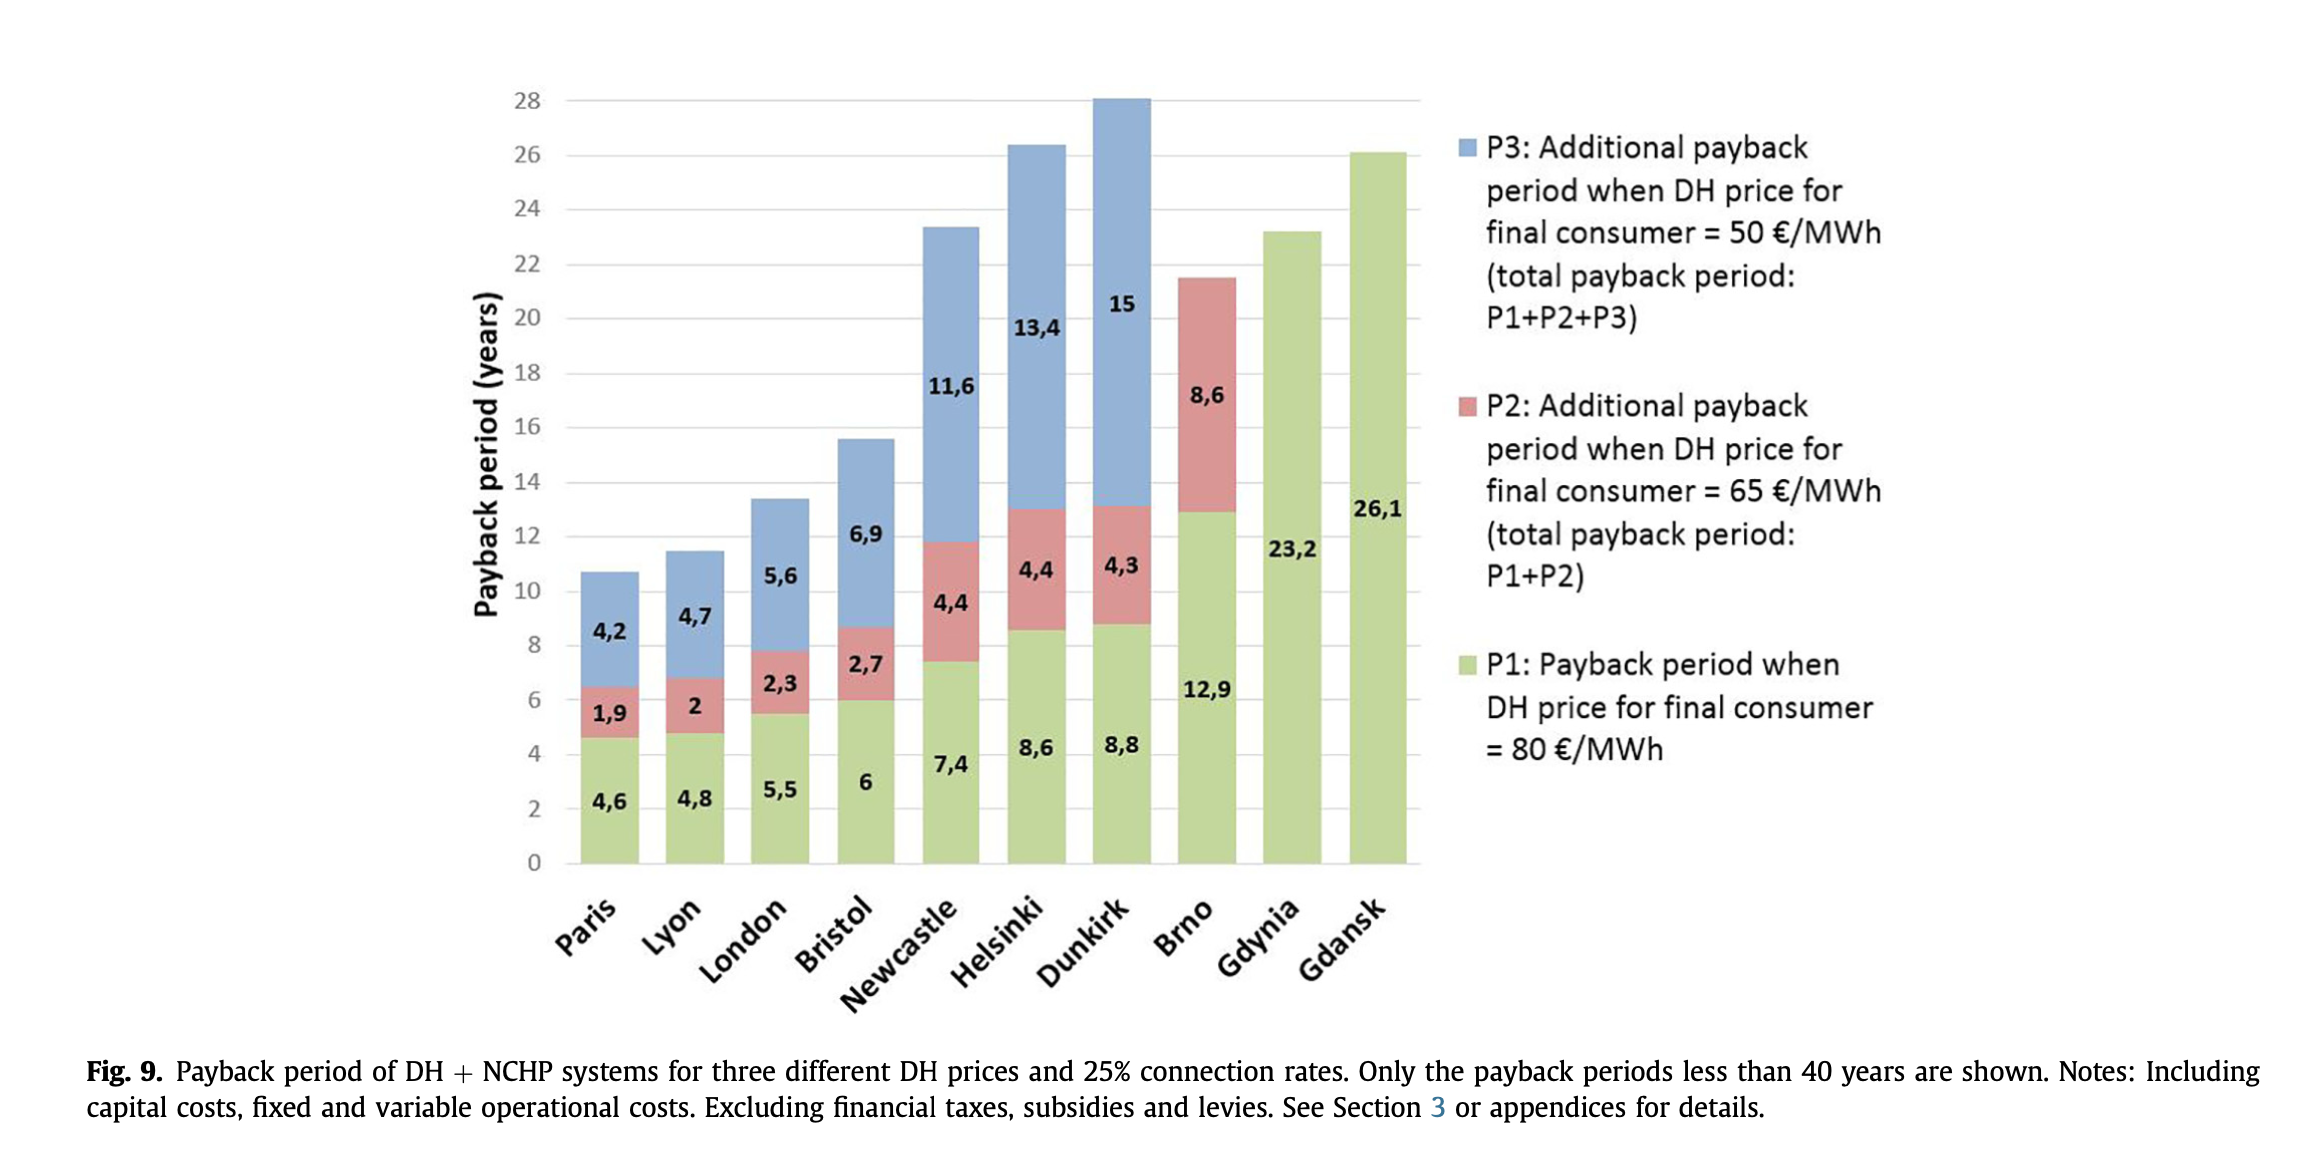

# Sensitivity Analysis

# UPDATE

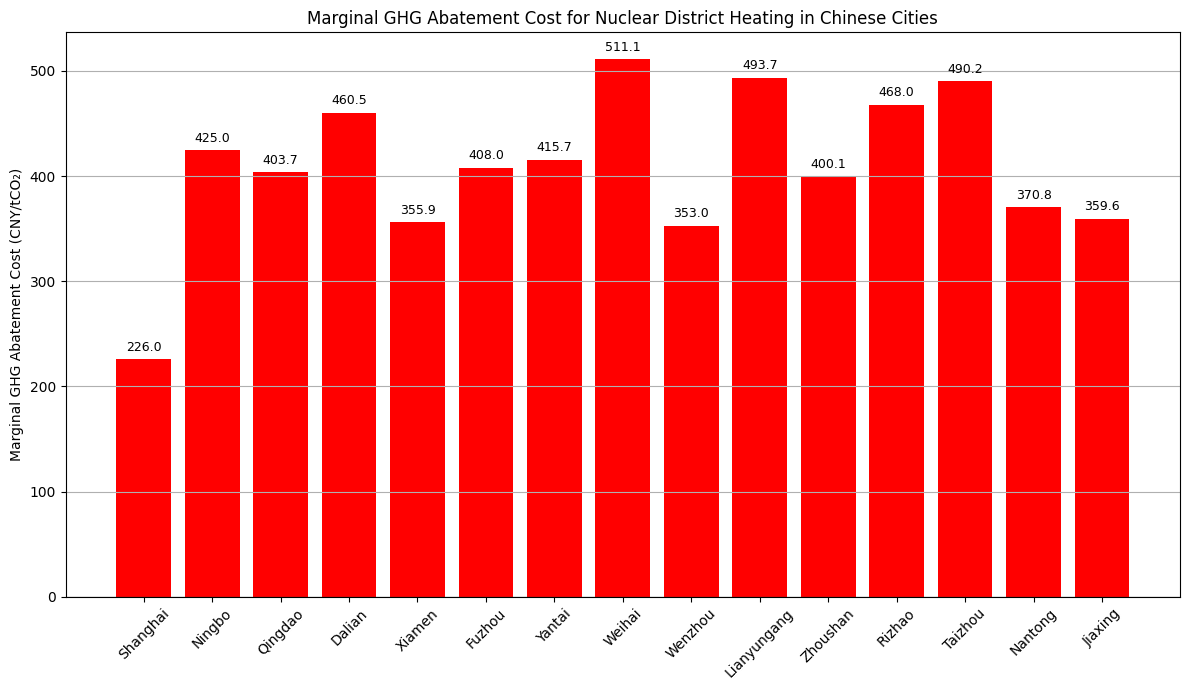

In [90]:
# Updated code to run analysis and comprehensive sensitivity analysis for each city

results = []
sensitivity_results = []

# Sensitivity parameter ranges
dh_price_range = np.arange(250, 450, 25)            # DH price (CNY/MWh)
social_benefit_range = np.arange(20, 100, 10)       # Social benefit (CNY/MWh)
environmental_benefit_range = np.arange(50, 200, 25) # Environmental benefit (CNY/MWh)
transport_distance_range = np.arange(5, 50, 5)      # Distance (km)
discount_rate_range = np.linspace(0.02, 0.08, 7)    # Discount rate (2% to 8%)
cost_params = ['capex', 'opex', 'DH_PRICE']

for idx, city_data in cities_data.iterrows():
    heat_demand = city_data['Q_s']
    linear_density = linear_heat_density(city_data['A_L'], heat_demand, city_data['Q_B'])
    capex = calculate_capex(heat_demand, city_data['distance'], linear_density)
    opex = calculate_opex(capex)

    total_annual_benefits = (SOCIAL_BENEFIT + HEALTH_BENEFIT + ENVIRONMENTAL_BENEFIT) * heat_demand
    annual_revenue_with_benefits = (heat_demand * DH_PRICE) + total_annual_benefits

    lcoh = calculate_lcoh(capex, opex, heat_demand)
    npv = calculate_npv(capex, opex, annual_revenue_with_benefits)
    irr = calculate_irr(capex, opex, annual_revenue_with_benefits)
    payback = calculate_payback(capex, opex, annual_revenue_with_benefits)
    mg_ghg_cost = marginal_ghg_cost(lcoh, heat_demand, city_data['E_BAU'], city_data['E_DH_NCHP'])

    results.append({
        "City": city_data['city'],
        "LCOH": lcoh,
        "NPV": npv,
        "IRR": irr,
        "Payback": payback,
        "Marginal GHG Cost": mg_ghg_cost
    })

    # Perform sensitivity analysis for each parameter
    for param, values in zip(['DH_PRICE', 'SOCIAL_BENEFIT', 'ENVIRONMENTAL_BENEFIT', 'distance', 'DISCOUNT_RATE'],
                             [dh_price_range, social_benefit_range, environmental_benefit_range, transport_distance_range, discount_rate_range]):
        for value in values:
            temp_city_data = city_data.copy()

            # Adjust parameters based on the sensitivity analysis
            if param in ['DH_PRICE', 'SOCIAL_BENEFIT', 'ENVIRONMENTAL_BENEFIT']:
                globals()[param] = value
            elif param == 'distance':
                temp_city_data['distance'] = value
            elif param == 'DISCOUNT_RATE':
                globals()['DISCOUNT_RATE'] = value

            linear_density_sa = linear_heat_density(temp_city_data['A_L'], heat_demand, temp_city_data['Q_B'])
            capex_sa = calculate_capex(heat_demand, temp_city_data['distance'], linear_density_sa)
            opex_sa = calculate_opex(capex_sa)
            annual_revenue_with_benefits_sa = (heat_demand * DH_PRICE) + (SOCIAL_BENEFIT + HEALTH_BENEFIT + ENVIRONMENTAL_BENEFIT) * heat_demand

            lcoh_sa = calculate_lcoh(capex_sa, opex_sa, heat_demand)
            npv_sa = calculate_npv(capex_sa, opex_sa, annual_revenue_with_benefits_sa)

            sensitivity_results.append({
                "City": temp_city_data['city'],
                "Parameter": param,
                "Value": value,
                "Adjusted LCOH": lcoh_sa,
                "Adjusted NPV": npv_sa
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
sensitivity_df = pd.DataFrame(sensitivity_results)

# Reset original constants for further calculations
DH_PRICE = 350
SOCIAL_BENEFIT = 50
ENVIRONMENTAL_BENEFIT = 120
DISCOUNT_RATE = 0.035

# Visualization: Marginal GHG Abatement Cost
plt.figure(figsize=(12, 7))
bars = plt.bar(results_df['City'], results_df['Marginal GHG Cost'], color=['green' if cost < 0 else 'red' for cost in results_df['Marginal GHG Cost']])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (5 if yval > 0 else -15), f'{yval:.1f}',
             ha='center', va='bottom' if yval > 0 else 'top', fontsize=9)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Marginal GHG Abatement Cost for Nuclear District Heating in Chinese Cities')
plt.ylabel('Marginal GHG Abatement Cost (CNY/tCO₂)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [91]:
sensitivity_df.head(100)

,City,Parameter,Value,Adjusted LCOH,Adjusted NPV
0,Shanghai,DH_PRICE,250.0,51.989637,4.497478e+08
1,Shanghai,DH_PRICE,275.0,51.989637,4.737722e+08
2,Shanghai,DH_PRICE,300.0,51.989637,4.977967e+08
3,Shanghai,DH_PRICE,325.0,51.989637,5.218212e+08
4,Shanghai,DH_PRICE,350.0,51.989637,5.458456e+08
...,...,...,...,...,...
95,Qingdao,ENVIRONMENTAL_BENEFIT,125.0,104.961295,3.104762e+08
96,Qingdao,ENVIRONMENTAL_BENEFIT,150.0,104.961295,3.226990e+08
97,Qingdao,ENVIRONMENTAL_BENEFIT,175.0,104.961295,3.349217e+08
98,Qingdao,distance,5.0,38.494092,3.674181e+08


In [92]:
sensitivity_df['Parameter'].unique()

array(['DH_PRICE', 'SOCIAL_BENEFIT', 'ENVIRONMENTAL_BENEFIT', 'distance',
       'DISCOUNT_RATE'], dtype=object)

In [93]:
results_df

,City,LCOH,NPV,IRR,Payback,Marginal GHG Cost
0,Shanghai,51.989637,5.458456e+08,0.886200,1.128413,226.041902
1,Ningbo,102.006563,3.117541e+08,0.851801,1.173983,425.027347
2,Qingdao,104.961295,3.349217e+08,0.826978,1.209222,403.697287
3,Dalian,124.324549,3.333927e+08,0.693506,1.441949,460.461292
4,Xiamen,78.303294,2.970348e+08,1.118732,0.893869,355.924062
5,Fuzhou,101.989388,2.953534e+08,0.851950,1.173778,407.957553
6,Yantai,116.387141,3.213029e+08,0.742848,1.346171,415.668362
7,Weihai,117.558975,2.726324e+08,0.735144,1.360278,511.125979
8,Wenzhou,84.719873,3.111771e+08,1.031729,0.969247,352.999471
9,Lianyungang,128.367129,3.076989e+08,0.670721,1.490933,493.719729
